## Dataset: notMNIST

In this mini project (Udacity Deep Learning), I will investigate the `notMNIST` dataset containing various letters of different fonts. Then I will build a neural network to recognize the letters.

The `notMNIST` data is provided [here](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This dataset is named `notMNIST` to prevent confusion with [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. However, `notMNIST` is a harder task and the data is a lot less _clean_ than MNIST.

## Requirement

I use: `Python-3.5.2`, `jupyter-1.0.0`, `numpy-1.11.2`, `scikit-learn-0.18.1`, `matplotlib-1.5.3`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
import pickle

## Data retrieve

The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. In here, I download the data to a separate folder due to its size.

In [10]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes, force=False, prefix='../../../../LargeData/'):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(prefix+filename):
        filename, _ = urlretrieve(url + filename, prefix+filename)
    else:
        filename = prefix+filename
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
        'Failed to verify' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ../../../../LargeData/notMNIST_large.tar.gz
Found and verified ../../../../LargeData/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file to a set of directories A-J

In [6]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False, prefix='../../../../LargeData/'):
    root = os.path.splitext(os.path.splitext(prefix+filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(prefix+filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [7]:
# Cell author : Hoang NT
# Cell : Display random images for each category to check data

import random
disp_num = 1

def dispImgsInFolderList(folder_list, dsp_num) :
    img_count = 0
    if len(folder_list) == 0 :
        print('Empty folder list')
        return img_count
    if dsp_num < 1 :
        print('Nothing to display')
        return img_count
    for folder in folder_list :
        if not os.path.isdir(folder) or len(os.listdir(folder)) == 0 :
            print('Folder %s not found or empty. Continuing...' % (folder))
            continue
        imgs = random.sample(os.listdir(folder), dsp_num)
        for img in imgs :
            display(Image(os.path.join(folder, img)))
            img_count += 1
    return img_count
            
dispImgsInFolderList(train_folders, disp_num)
dispImgsInFolderList(test_folders, disp_num)

10

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

10

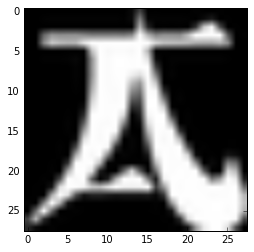

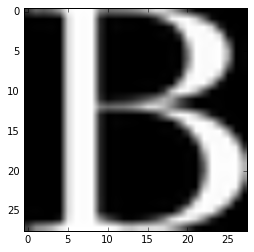

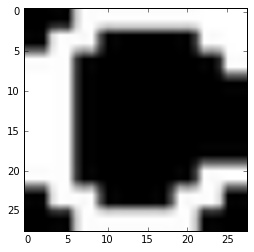

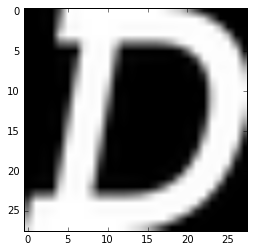

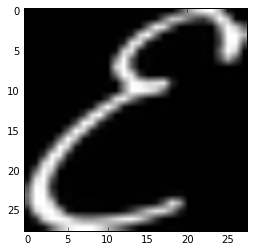

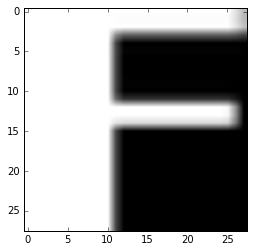

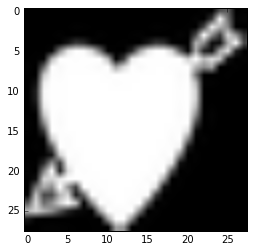

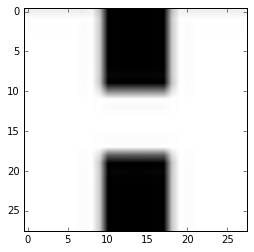

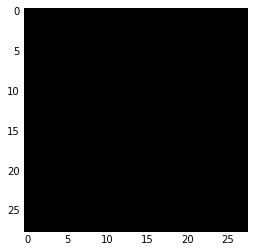

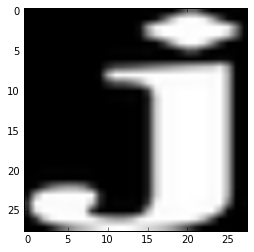

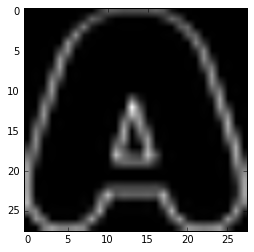

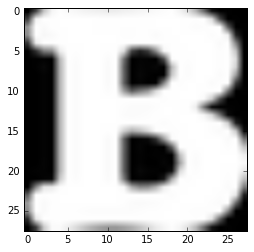

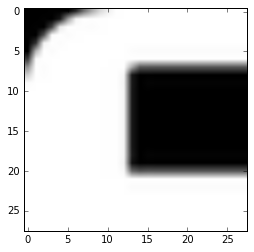

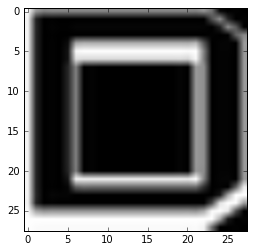

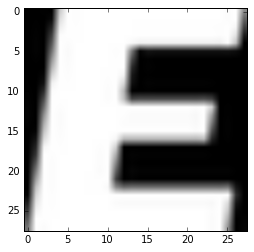

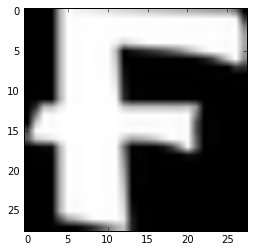

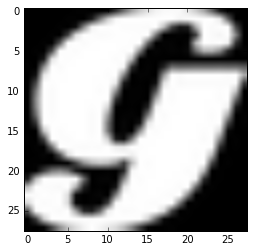

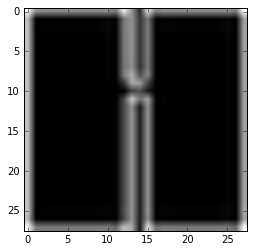

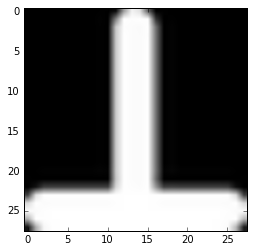

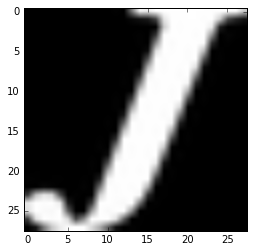

In [18]:
# Cell author : Hoang NT
# Cell : Display normalized images and its labels stored in pickle files.

%matplotlib inline

label_lookup = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

def dispImgsInPickleList(pickle_list, dsp_num) :
    img_count = 0
    if len(pickle_list) == 0 :
        print('Empty pickle list')
        return img_count
    if dsp_num == 0 :
        print('Nothing to display')
        return img_count
    for pickle_file in pickle_list :
        if not os.path.exists(pickle_file) :
            print('File %s not found. Continuing...' % (pickle_file))
            continue
        pfile = open(pickle_file, 'rb')
        data = pickle.load(pfile)
        imgs = random.sample(data, dsp_num)
        for img in imgs :
            fig = plt.figure()
            fig.add_subplot
            plt.imshow(img, cmap='gray', interpolation='none')
            img_count += 1
    return img_count

dispImgsInPickleList(train_datasets, disp_num)
dispImgsInPickleList(test_datasets, disp_num)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [23]:
# Cell author : Hoang NT
# Cell : Display data count for each datasets and verify if the data is balanced with a threshold for checking.

plt.close("all") # Close all plots in the previous cells to free memory.

threshold = 0.95

def listDataSize(data_list, thres) :
    if len(data_list) == 0 :
        return 0;
    if not 0 < thres < 1 :
        raise Exception('Unexpected threshold value: %f. Expected value in range (0,1).' % thres)
    data_sizes = []
    for data in data_list :
        if not os.path.exists(data) :
            print('Dataset %s not found. Continuing...' % (data))
        pfile = open(data, 'rb')
        rdata = pickle.load(pfile)
        print('%s size = %d' % (data, len(rdata)))
        data_sizes.append(len(rdata))
    avg = float(sum(data_sizes)) / len(data_sizes)
    dev = float(1 - 0.95) * avg
    
    for size in data_sizes :
        if abs(size - avg) > dev :
            print('Dataset %s is unbalanced. Avg: %f, value: %d' % (avg, size,data_list[0].split('\\')[0]))
            break;
    else :
        print('Dataset %s is balanced.' % (data_list[0].split('\\')[0]))
        
    return len(data_sizes)
        
listDataSize(test_datasets,threshold)
listDataSize(train_datasets,threshold)

notMNIST_small\A.pickle size = 1872
notMNIST_small\B.pickle size = 1873
notMNIST_small\C.pickle size = 1873
notMNIST_small\D.pickle size = 1873
notMNIST_small\E.pickle size = 1873
notMNIST_small\F.pickle size = 1872
notMNIST_small\G.pickle size = 1872
notMNIST_small\H.pickle size = 1872
notMNIST_small\I.pickle size = 1872
notMNIST_small\J.pickle size = 1872
Dataset notMNIST_small is balanced.
notMNIST_large\A.pickle size = 52909
notMNIST_large\B.pickle size = 52911
notMNIST_large\C.pickle size = 52912
notMNIST_large\D.pickle size = 52911
notMNIST_large\E.pickle size = 52912
notMNIST_large\F.pickle size = 52912
notMNIST_large\G.pickle size = 52912
notMNIST_large\H.pickle size = 52912
notMNIST_large\I.pickle size = 52912
notMNIST_large\J.pickle size = 52911
Dataset notMNIST_large is balanced.


10

In [24]:
# Dump necessary files for later, don't have to re-run previous cells
if not os.path.exists('train_datasets.pickle') :
    pickle.dump(train_datasets, open('train_datasets.pickle', 'wb'), pickle.HIGHEST_PROTOCOL)
if not os.path.exists('test_datasets.pickle') :
    pickle.dump(test_datasets, open('test_datasets.pickle', 'wb'), pickle.HIGHEST_PROTOCOL)

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [22]:
# nb_rows : number of rows.
# img_size : make array to store nb_rows images of size: img_size x img_size
# This function create and return placeholder for data.
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

# This function loads and merges the pickle files in the pickle_files list
# into one dataset and a corresponding label vector. If the valid_size is 
# not specified, there is only one (big) dataset returned. Else, the datasets
# will be divided into a training set and a validating set.
def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000L, 28L, 28L) (200000L,)
Validation: (10000L, 28L, 28L) (10000L,)
Testing: (10000L, 28L, 28L) (10000L,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [23]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

10

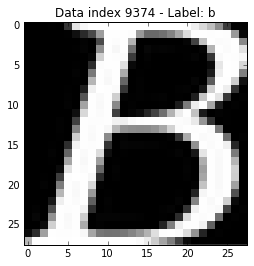

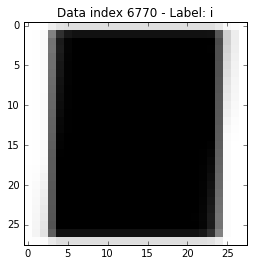

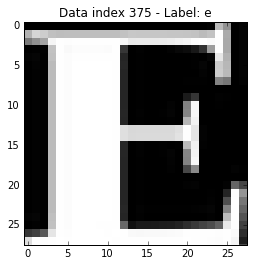

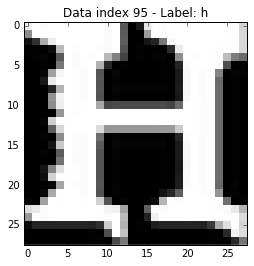

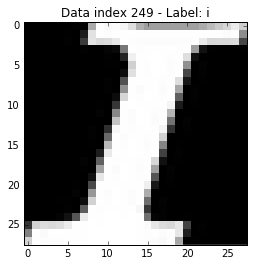

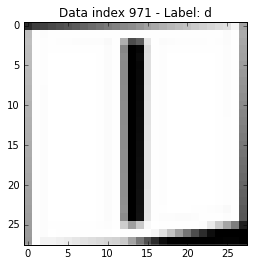

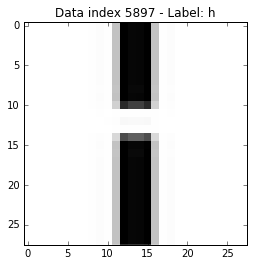

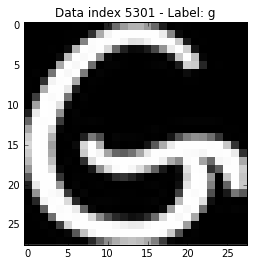

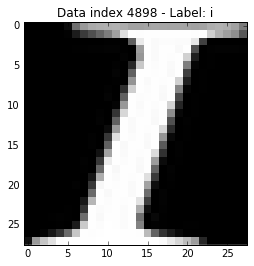

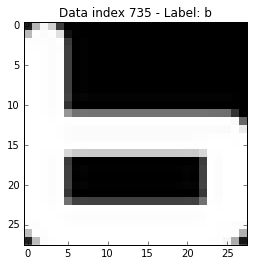

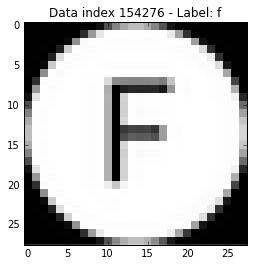

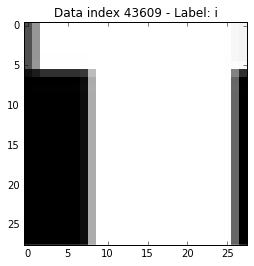

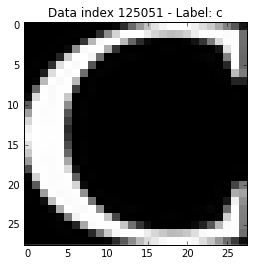

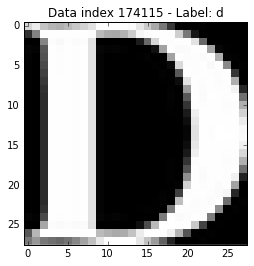

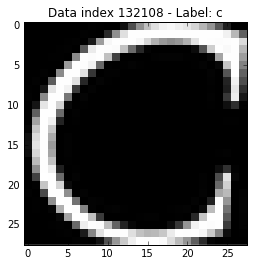

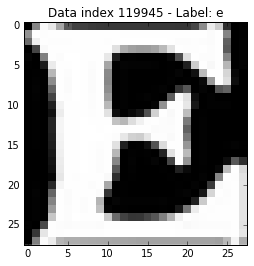

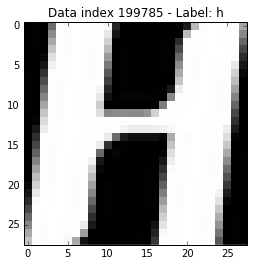

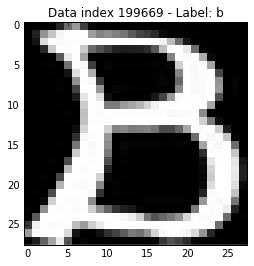

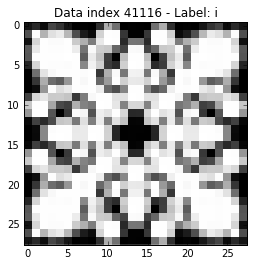

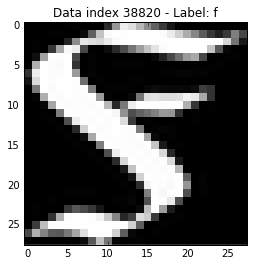

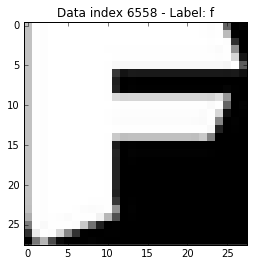

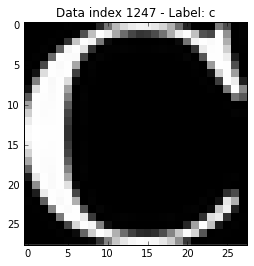

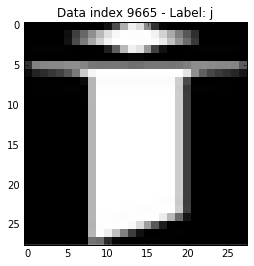

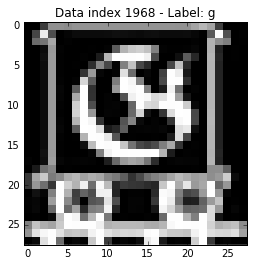

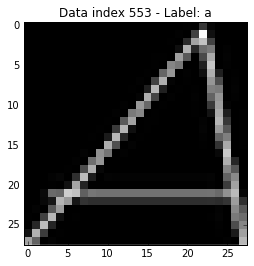

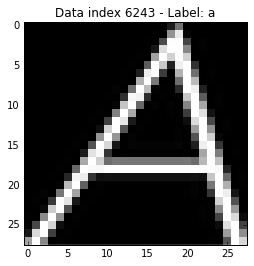

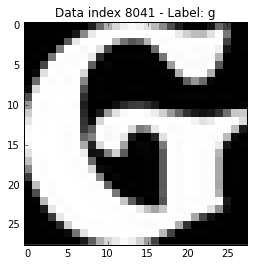

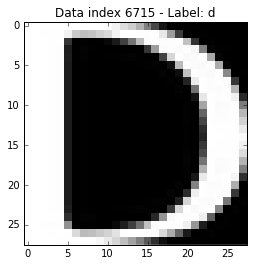

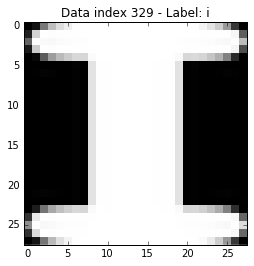

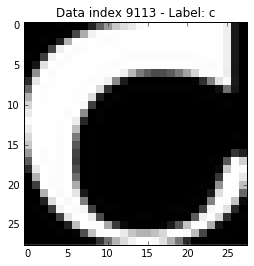

In [27]:
# Cell author : Hoang NT
# Cell : Select random data in datasets in its corresponding label to check if the data is still good.
%matplotlib inline

check_size = 10
plt.close("all")
def check_dataset(dataset, labels, test_sz) :
    data_count = 0
    data_size = len(dataset)
    if not data_size > 0 :
        print('Empty dataset')
        return data_count;
    if not data_size == len(labels) :
        raise Exception('Dataset and label do not have same size')
    indices = np.arange(data_size)
    random_data = random.sample(indices, test_sz)
    for i in random_data :
        data_count += 1
        plt.figure()
        plt.title('Data index %d - Label: %s' % (i, label_lookup[labels[i]]))
        plt.imshow(dataset[i], cmap='gray', interpolation='none') # Gray scale and no smoothing the images out
    return data_count

check_dataset(test_dataset, test_labels, check_size)
check_dataset(train_dataset, train_labels, check_size)
check_dataset(valid_dataset, valid_labels, check_size)




Finally, let's save the data for later reuse:

In [40]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [41]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800451


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

Overlap ratio for test dataset is: 0.020600
Overlap ratio for validation dataset is: 0.014100
Overlap ratio for train dataset is: 0.063280
Overlap ratio between train dataset and test dataset is : 0.017650
Overlap ratio between train dataset and validation dataset is : 0.017650
Overlap ratio between test dataset and validation dataset is : 0.016300
Sanitized test dataset samples:
Sanitized validation dataset samples:


5

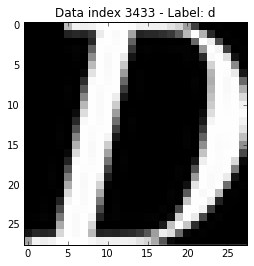

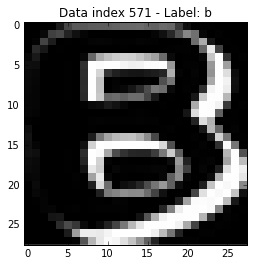

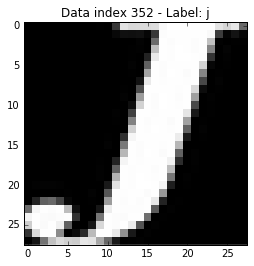

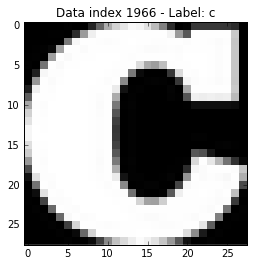

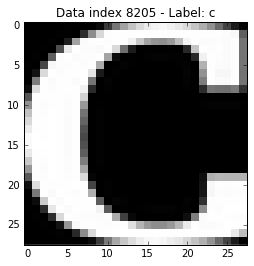

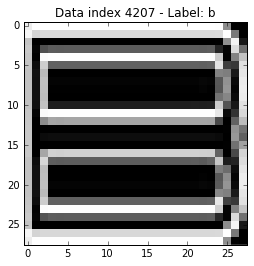

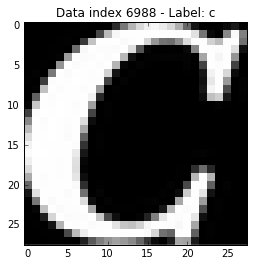

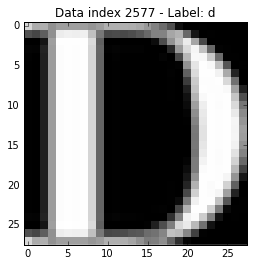

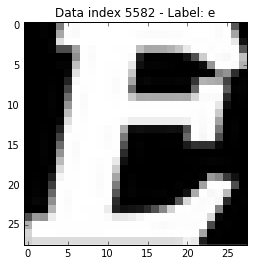

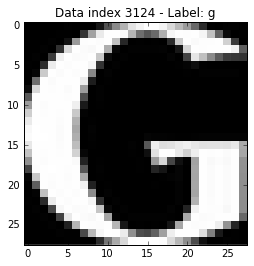

In [68]:
# Cell author : Hoang NT
# Cell : Check and print the overlap degree:
### - Within a dataset itself
### - Across datasets
### - Create a sanitized validation and test set. Compare the accuracy in problem 6
### (?) How about near duplicates between datasets? [Array comparision returns array of true/false, count the true and 
###                                                  compare this count with a number maybe?]

plt.close("all") # Free memory by closing all previous plot

# load data set (a dictionary with 6 keys for 3 pairs of data-label)
if not 'pickle_file' in locals() :
    pickle_file = 'notMNIST.pickle'

pfile = open(pickle_file, 'rb')
datasets = pickle.load(pfile)

assert len(datasets) == 6

# Return a dataset with all unique data 
# Requires make_arrays function from [22]. 
def removeDuplicates(dataset, labels) :
    i = 0
    unique_dict = {}
    unique_datasets, unique_labels = make_arrays(len(labels), image_size)
    for j, data in enumerate(dataset) :
        tkey = data.flatten().tostring()
        if not unique_dict.has_key(tkey) :
            unique_dict[tkey] = j
            unique_datasets[i,:,:] = data
            unique_labels[i] = labels[j]
            i += 1
    return unique_datasets[:i], unique_labels[:i]

# Compare data overlap between 2 datasets
# Return overlap ratio.
def overlap(datasetA, datasetB) :
    dictSet = datasetA;
    otherSet = datasetB;
    if len(datasetA) > len(datasetB) :
        dictSet = datasetB
        otherSet = datasetA
    dic = {}
    # Create a dictionary from data
    for i, data in enumerate(dictSet) :
        tkey = data.flatten().tostring()
        dic[tkey] = 1
    dup_count = 0
    for data in otherSet :
        tkey = data.flatten().tostring()
        if dic.has_key(tkey) :
            dup_count += dic[tkey] # <- increase by number of occurence in the other list.
    return dup_count

# Create a sanitized version set2 dataset
# Remove overlap between set1 and set2
def sanitize(set1, set2, labels2) :
    dic = {}
    
    dataset, labels = make_arrays(len(labels2), image_size)
    
    for data in set1 :
        tkey = data.flatten().tostring()
        dic[tkey] = 1
            
    j = 0
    for i, data in enumerate(set2) :
        tkey = data.flatten().tostring()
        if not dic.has_key(tkey) :
            dataset[j,:,:] = data
            labels[j] = labels2[i]
            j += 1
    return dataset[:j], labels[:j]


unique_test_datasets, unique_test_labels = removeDuplicates(datasets.get('test_dataset'), datasets.get('test_labels'))
unique_valid_datasets, unique_valid_labels = removeDuplicates(datasets.get('valid_dataset'), datasets.get('valid_labels'))
unique_train_datasets, unique_train_labels = removeDuplicates(datasets.get('train_dataset'), datasets.get('train_labels'))

print('Overlap ratio for test dataset is: %f' % (1 - len(unique_test_labels) / len(datasets.get('test_labels'))))
print('Overlap ratio for validation dataset is: %f' % (1 - len(unique_valid_labels) / len(datasets.get('valid_labels'))))
print('Overlap ratio for train dataset is: %f' % (1 - len(unique_train_labels) / len(datasets.get('train_labels'))))

print('Overlap ratio between train dataset and test dataset is : %f' % 
            (overlap(datasets.get('train_dataset'), datasets.get('test_dataset'))/len(datasets.get('train_labels'))))
print('Overlap ratio between train dataset and validation dataset is : %f' % 
            (overlap(datasets.get('train_dataset'), datasets.get('valid_dataset'))/len(datasets.get('train_labels'))))
print('Overlap ratio between test dataset and validation dataset is : %f' % 
            (overlap(datasets.get('test_dataset'), datasets.get('valid_dataset'))/len(datasets.get('valid_labels'))))

sanitized_test_dataset, sanitized_test_labels = sanitize(unique_train_datasets, 
                                                         datasets.get('test_dataset'), datasets.get('test_labels'))
sanitized_valid_dataset, sanitized_valid_labels = sanitize(unique_train_datasets, 
                                                         datasets.get('valid_dataset'), datasets.get('valid_labels'))

# Quick visual check for correctness of data
plt.close("all")
check_dataset(sanitized_test_dataset, sanitized_test_labels, 5)
check_dataset(sanitized_valid_dataset, sanitized_valid_labels, 5)


[The overlap ratio between train dataset with validation dataset / test dataset is the same! This can be co-incident since the cross check between two datasets return a low ratio.]

In [69]:
# Cell author : Hoang NT
# Cell : Pack sanitized test dataset and validation dataset for future use

sanitized_data = [sanitized_test_dataset, sanitized_test_labels, sanitized_valid_dataset, sanitized_valid_labels]

sanitized_filename = ['sanitized_test_dataset.pickle', 'sanitized_test_labels.pickle', 
                      'sanitized_valid_dataset.pickle', 'sanitized_valid_labels.pickle']

for i in range(0,4) :
    if not (os.path.exists(sanitized_filename[i])) :
        pfile = open(sanitized_filename[i], 'wb')
        print ('Dumping %s ...' % (sanitized_filename[i]))
        pickle.dump(sanitized_data[i], pfile, pickle.HIGHEST_PROTOCOL)
    else :
        print ('Pickle file \'%s\' already exists. Skipping ...' % (sanitized_filename[i]))

Dumping sanitized_test_dataset.pickle ...
Dumping sanitized_test_labels.pickle ...
Dumping sanitized_valid_dataset.pickle ...
Dumping sanitized_valid_labels.pickle ...


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [93]:
# Cell author : Hoang NT
# Cell : Using LogisticRegression model from sklearn.linear_model to fit the data with different size

model_filename = 'LogisticRegression_notMNIST_200K_20160304.pickle'

def GetLogisticRegression(data, labels, filename) :
    # Check if there is a pre-trained model saved as a pickle file
    if os.path.exists(filename) :
        print('There is already a model saved. Skip training and load the trained model from file ... \n')
        f = open(filename, 'rb')
        model = pickle.load(f)
        return model
    # Create an "empty" default Logistic Regression Model
    LG = LogisticRegression()
    # Flatten out data if needed for the Logistic Regression Model training
    if len(data.shape) >= 3 :
        data = data.reshape((len(data), image_size * image_size))
    if len(labels.shape) >= 2 :
        labels = labels.reshape((len(labels)))
    print ('Training model. This process will take awhile, please wait.')
    LG.fit(data, labels)
    f = open(filename, 'wb')
    pickle.dump(LG, f, pickle.HIGHEST_PROTOCOL)
    return LG

def accuracy(test_data, test_labels, model = None, filename = None) :
    if model == None :
        if filename == None :
            print ('Model or filename must be specified. Nothing is returned.')
            return 0
        else :
            if not os.path.splitext(filename)[-1] == '.pickle' :
                print ('Pickle filename is required. Nothing is returned.')
                return 0
            f = open(filename, 'rb')
            model = pickle.load(f)
    if len(test_data.shape) >= 3 :
        test_data = test_data.reshape((len(test_data), image_size * image_size))
    predictions = model.predict(test_data)
    if not len(test_labels) == len(predictions) :
        print ('Something is wrong with the data. Length mismatch in test process.')
        return 0
    error_count = 0
    for i in range (len(predictions)) :
        if not predictions[i] == test_labels[i] :
            error_count += 1
    return error_count / len(test_labels)

model = GetLogisticRegression(datasets.get('train_dataset'), datasets.get('train_labels'), model_filename)
acc_test = accuracy(datasets.get('test_dataset'), datasets.get('test_labels'), model, None)
acc_valid = accuracy(datasets.get('valid_dataset'), datasets.get('valid_labels'), model, None)
acc_san_test = accuracy(sanitized_test_dataset, sanitized_test_labels, model, None)
acc_san_valid = accuracy(sanitized_valid_dataset, sanitized_valid_labels, model, None)

print('Accuracy testing on test dataset: %f' % (acc_test))
print('Accuracy testing on validation dataset: %f' % (acc_valid))
print('Accuracy testing on sanitized test dataset: %f' % (acc_san_test))
print('Accuracy testing on sanitized validation dataset: %f' % (acc_san_valid))
        
    

There is already a model saved. Skip training and load the trained model from file ... 

Accuracy testing on test dataset: 0.106400
Accuracy testing on validation dataset: 0.170500
Accuracy testing on sanitized test dataset: 0.117070
Accuracy testing on sanitized validation dataset: 0.179547


[The performance of the Logistic Linear Regression model is very low. This fact is reasonable since the problem itself is a non-linear problem.]